In [ ]:
!pip install fake-useragent

Сначала нужно спарсить новости с сайта

In [ ]:
import requests
from pprint import pprint
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pandas as pd
from time import sleep

Дальше представлен парсинг новостей, где информация сохраняется в формате txt и csv

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from time import sleep

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

def get_url():
    base_url = 'https://gorodkirov.ru'
    for count in range(1, 60):
        url = f"https://gorodkirov.ru/news/?page={count}"
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "lxml")
        data = soup.find_all("article", class_="card__item")
        for i in data:
            news = i.find('a').get('href')
            full_url = f"{base_url}{news}"
            yield full_url

def get_data():
    for news in get_url():
        response = requests.get(news, headers=headers)
        sleep(2)
        soup = BeautifulSoup(response.text, "lxml")
        try:
            data = soup.find("article", class_="article-block")
            header = data.find("h1", class_="title").text
            date = data.find("time", class_="article-header__time").text
            text = data.find("div", class_="article-block__text").text
            author = data.find("span", class_="author__name").text
        except Exception as error:
            text = f'Возникает ошибка {error} в новости {news}'
        yield header, date, text, author, news

def dataframe():
    data_list = []
    for header, date, text, author, news in get_data():
        data_list.append([header, date.strip(), text, author, news])
    df = pd.DataFrame(data_list, columns=['Заголовок', 'Дата публикации', 'Текст', 'Автор', 'Ссылка'])
    df.to_csv('info_Kirov.csv', index=False)

    with open('info_Kirov.txt', 'w', encoding='utf-8') as file:
        for header, date, text, author, news in get_data():
            file.write("======" + "\n")
            file.write(news + "\n")
            file.write("Город Киров" + "\n")
            file.write(date.strip() + "\n")
            file.write(author + "\n")
            file.write(header + "\n")
            file.write(text + "\n\n")

# Вызов функции для создания датафрейма и сохранения данных в CSV файл
dataframe()

In [ ]:
! pip install nltk

Из csv файла будем анализировать именно текст новостей, поэтому выбираем его из данных

In [ ]:
import pandas as pd

# Чтение файла CSV
df = pd.read_csv('info_Kirov final.csv')

# Извлечение текста из определенного столбца
column_name = 'Текст'  # Название столбца, из которого нужно извлечь текст
text_data = df[column_name].tolist()

# Запись текста в файл
with open('only_text.txt', 'w', encoding='utf-8') as f:
    for line in text_data:
        f.write(line + '\n')

In [2]:
! pip install torch
! pip install spacy networkx
! python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 37.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Лемматизируем текст,  строим граф, считаем меру кластерности

In [7]:
import spacy
import networkx as nx
from itertools import combinations

# Загрузка модели для русского языка
nlp = spacy.load("ru_core_news_sm")  # загружаем предобученную модель для русского языка
nlp.max_length = 2000000  # увеличиваем максимальную длину текста до 2000000 символов

# Функция для загрузки текста из файла
def load_text_from_file(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Функция для лемматизации текста и удаления стоп-слов и пунктуации
def preprocess_text(text):
    doc = nlp(text)  # токенизация, лемматизация
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]  # исключаем стоп-слова, знаки препинания, цифры и прочие штуки, оставляем буквы
    return words

# Функция для создания графа текста
def build_text_graph(words, window_size=2): # window_size - размер окна для анализа
    G = nx.Graph()  # создаем пустой граф
    G.add_nodes_from(words)  # добавляем все слова в качестве вершин
    for i in range(len(words) - window_size + 1):  # проходим по всем словам в списке
        window = words[i:i + window_size]
        for w1, w2 in combinations(window, 2):  # перебираем все пары слов в текущем списке
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1  # Если ребро между этими двумя словами уже существует, увеличиваем его вес на 1
            else:
                G.add_edge(w1, w2, weight=1)  # Если ребра нет, создаем его с весом 1
    return G

# Функция для вычисления меры кластерности
def compute_clustering_coefficients(graph):
    return nx.clustering(graph, weight='weight')  # эта функция из библиотеки NetworkX вычисляет коэффициент кластеризации для каждой вершины в графе
# параметр weight указывает, что при вычислении коэффициента кластеризации должны учитываться веса ребер

# Функция для вывода топ-10 слов по мере кластерности
def print_top_clustering_words(clustering_coefficients, top_n=50):
    sorted_clustering = sorted(clustering_coefficients.items(), key=lambda item: item[1], reverse=True)
    top_clustering = sorted_clustering[:top_n]
    print("Слова с наибольшей мерой кластерности:")
    for word, coeff in top_clustering:
        print(f"Слово: {word}, Мера кластерности: {coeff}")

# код с входными данными
filename = 'only_text.txt'  # файл с текстом новостей
text = load_text_from_file(filename)
words = preprocess_text(text)
text_graph = build_text_graph(words)  # граф текста
clustering_coefficients = compute_clustering_coefficients(text_graph)
print_top_clustering_words(clustering_coefficients)

Слова с наибольшей мерой кластерности:
Слово: фв, Мера кластерности: 0.009792198347303412
Слово: коментария, Мера кластерности: 0.004908718041764424
Слово: межрегионгаз, Мера кластерности: 0.004497663598461995
Слово: доследственный, Мера кластерности: 0.004360512759339792
Слово: некоммерческий, Мера кластерности: 0.004175261027193573
Слово: жданов, Мера кластерности: 0.003875968992248062
Слово: газораспределение, Мера кластерности: 0.003875968992248062
Слово: подгорный, Мера кластерности: 0.003875968992248062
Слово: kazanfirst, Мера кластерности: 0.0037934763964814567
Слово: пролетарский, Мера кластерности: 0.0037072309743650944
Слово: летательный, Мера кластерности: 0.0035697979637988246
Слово: кафедральный, Мера кластерности: 0.0035215515364963946
Слово: гострудинспекции, Мера кластерности: 0.003242562691226896
Слово: многоэтажке, Мера кластерности: 0.0030821676366919724
Слово: прогреметь, Мера кластерности: 0.0030439735003792564
Слово: гололед, Мера кластерности: 0.00301088421119559

Визуализация графа

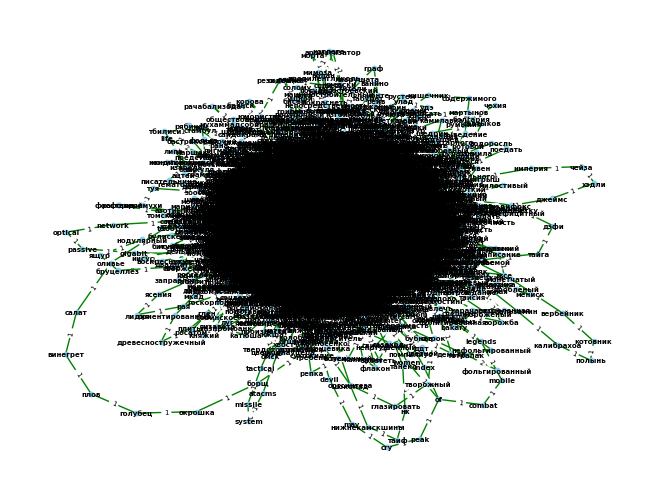

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# рисуем граф
pos = nx.spring_layout(text_graph)  # вершины графа
nx.draw(text_graph, pos, with_labels=True, node_size=10, node_color='skyblue', edge_color='g', font_size=5, font_weight='bold')  # Отрисовка вершин: выводим их параметры
edge_labels = nx.get_edge_attributes(text_graph, 'weight')  # Получение весов ребер
nx.draw_networkx_edge_labels(text_graph, pos, edge_labels=edge_labels, font_size=5)  # Отрисовка весов ребер
plt.show()

Смотрим творческое задание. Выведем топ 50 2-грамм, слова в которых часто встречаются вместе

In [23]:
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('punkt')

# Предобработка текста
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'\d+', '', text)  # Удаление чисел и специальных символов
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[a-z]', '', text)  # Удаление латиницы
    # Токенизация
    tokens = word_tokenize(text)
    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Получение текста и предобработка
with open('only_text.txt', 'r', encoding='utf-8') as file:
    text = file.read()
tokens = preprocess_text(text)

# Извлечение коллокаций (биграмм)
def extract_collocations(tokens, n=20):
    bigram_measures = BigramAssocMeasures() # Инициализация BigramCollocationFinder с мерой PMI
    finder = BigramCollocationFinder.from_words(tokens)
    collocations = finder.nbest(bigram_measures.pmi, n)  # Отбор топ-N коллокаций на основе PMI
    return collocations

# Получение топ-50 коллокаций
collocations = extract_collocations(tokens, n=50)
print("Топ-50 коллокаций:")
for collocation in collocations:
    print(collocation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Топ-50 коллокаций после предобработки:
('аа', 'рылова')
('абсолютная', 'нетерпимость')
('авантюрного', 'сериала')
('автовладельцы', 'нарушили')
('автоматы', 'даркнете')
('автомобилост', 'сдавтаься')
('автопокрышки', 'утилизацию')
('автопробеге', 'дорогами')
('авторами', 'произведениями')
('авторским', 'повторением')
('агатой', 'муцениеце')
('аглая', 'тарасова')
('агрессивно', 'нецензурно')
('агроному', 'начальнику')
('адвоката', 'налоговым')
('адекватных', 'целей')
('адлександре', 'спокойном')
('административно', 'высланы')
('адриа', 'архона')
('азатом', 'кадыровым')
('азии', 'восточной')
('азотной', 'кислотой')
('азотнофосфорный', 'раствор')
('ак', 'батыр')
('академиком', 'обществоведом')
('аккуранто', 'разобрать')
('акрон', 'тольятти')
('актера', 'юриста')
('активизировал', 'благотворительную')
('активы', 'арестованы')
('актуальным', 'темам')
('акцизах', 'вино')
('алания', 'амурской')
('александре', 'тебенькове')
('александровским', 'садом')
('алексеевны', 'постоянными')
('алисия', '

Pointwise Mutual Information (PMI) - это статистическая мера, которая измеряет степень взаимосвязи между двумя событиями. В контексте анализа текста PMI используется для оценки силы ассоциации между двумя словами (или биграммами), основываясь на их совместной встречаемости в корпусе текстов. (нагуглила)

Получились какие-то термины, имена и редко встречающиеся слова, которые почти всегда идут вместе (два слова)